# Generalized Time-Extended Networks
This Notebook explains how to use the code base to create a generalized time-expanded network.

In [ ]:
from auxiliary_functions_index.networkx_utilities import create_graph, create_graph_from_df, visualize_graph, cut_capacity
from auxiliary_functions_index.generalized_ext_network import aggregate_cut_time_points, create_A_inf, get_time_level, initialize_A_fin, create_A_fin, plot_GTEN
from auxiliary_functions_index.min_cut_LP import min_cut_over_time
from auxiliary_functions_index.max_flow_min_cut import static_max_flow, static_min_cut
import itertools
import pandas as pd

## Data
We consider a network (directed graph) where each arc has a capacity and a transit time. There are two designated subsets of nodes: sources and sinks. Additionally we need to specify a time horizon. 

In [2]:
arcs = [(1, 2), (1, 3), (2, 4), (3, 4), (2, 3)]  # Arcs in the network
capacities = {(1, 2): 1, (1, 3): 1, (2, 4): 1, (3, 4): 2, (2, 3): 2}  # Cost for each arc in the objective
transit_times = {(1, 2): 1, (1, 3): 1, (2, 4): 1, (3, 4): 1, (2, 3):0}  # Right-hand side values for each arc constraint
sources = [1]  # Nodes in S+ ∩ X where α should be 0
sinks = [4]  # Nodes in S- \ X where α should be T
time_horizon = 4  # The value of T

1. Step: Compute a Min Cut Over Time

In [3]:
# Compute the min cut values 
alpha, _ = min_cut_over_time(arcs, capacities, transit_times, time_horizon, sources, sinks)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-05
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 9 rows, 12 columns and 23 nonzeros
Model fingerprint: 0xbb41c9b9
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 5 rows and 7 columns
Presolve time: 0.01s
Presolved: 4 rows, 5 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.000000e+00   0.000000e+00      0s
       4    4.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.02 seconds (0.00 work units)
Optimal objective  4.000000000e+00
Optimal objective value: 4.0
y

Visualization of the results. Alpha labels indicate the minimum cut over time.

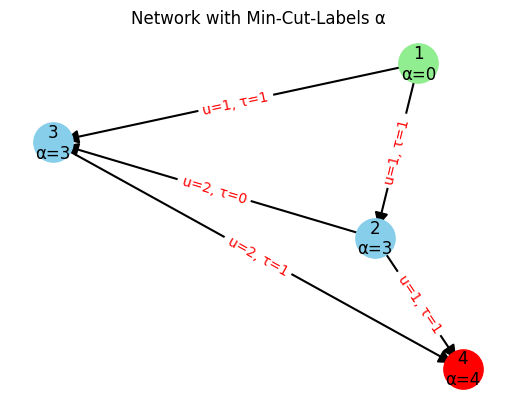

In [4]:
# Create the graph and display the Min-Cut-values
G = create_graph(arcs, capacities, transit_times, alpha=alpha)
visualize_graph(G, sources, sinks)

2. Step: Find all interesting time points 
$$\overset{\sim}{T} = \bigcup_{X\subset S\ :\ X\cap S^+ \neq \emptyset,\ S^-\setminus X \neq \emptyset } \{\alpha_{v,X} : v\in V\}$$

In [5]:
# Compute "interesting" time points, i.e. all time points of cuts over time for different subsets of terminals
time_points = aggregate_cut_time_points(sources, sinks, arcs, capacities, transit_times, time_horizon)
print('\n\nT~ =', time_points)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 9 rows, 12 columns and 23 nonzeros
Model fingerprint: 0xbb41c9b9
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 5 rows and 7 columns
Presolve time: 0.01s
Presolved: 4 rows, 5 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.000000e+00   0.000000e+00      0s
       4    4.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.000000000e+00
Optimal objective value: 4.0
y[(1, 2)] = 2.0
y[(1, 3)] = 2.0
y[(2, 4)] = 0.0
y[(3, 4)] = 0.0
y[(2, 3)] = 0.0
y[('psi', 1)

In [6]:
# Create two dctionaries assigning to each alpha-value (time point) the number of its coresponding time layer and vice versa
alpha_to_index = {time: idx + 1 for idx, time in enumerate(time_points)}
index_to_alpha = dict(enumerate(time_points, start=1))
index_to_alpha

{1: 0, 2: 3, 3: 4}

## Construction of the generalized time-expanded network
- Nodes $V^{\overset{\sim}{T}} = \{v^i : i \in \{1,\ldots,\overset{\sim}{T}\}, v\in V\}$
- "upward" arcs $A_{\infty}$
- arcs $A_{<\infty}$

3. Step: Construction of $A_\infty$

In [7]:
nodes = list(set([node for arc in arcs for node in arc]))
nodes_T_tilde = [f'{node}^{t}' for node, t in itertools.product(nodes, index_to_alpha.keys())]

df_inf = create_A_inf(nodes, index_to_alpha)
print('A_inf')
df_inf

A_inf


,v^i,w^j,capacity,length,alpha_v,alpha_w
0,1^1,1^2,inf,1,0,3
1,1^2,1^3,inf,1,3,4
2,2^1,2^2,inf,1,0,3
3,2^2,2^3,inf,1,3,4
4,3^1,3^2,inf,1,0,3
5,3^2,3^3,inf,1,3,4
6,4^1,4^2,inf,1,0,3
7,4^2,4^3,inf,1,3,4


3. Step: Construction of $A_{<\infty}$

In [8]:
df_fin = create_A_fin(arcs, time_points, capacities, transit_times, index_to_alpha)

index :  1 	 arc : (1^1, 2^2)
V_i_to_j =  ['1^1', '1^2']
W_i_to_j =  ['2^1', '2^2']
total cut capacity :  2
new cap of (1^1, 2^2) =  1
index :  7 	 arc : (1^1, 3^2)
V_i_to_j =  ['1^1', '1^2']
W_i_to_j =  ['3^1', '3^2']
total cut capacity :  2
new cap of (1^1, 3^2) =  1
index :  13 	 arc : (2^1, 4^2)
V_i_to_j =  ['2^1', '2^2']
W_i_to_j =  ['4^2', '4^1']
total cut capacity :  2
new cap of (2^1, 4^2) =  1
index :  19 	 arc : (3^1, 4^2)
V_i_to_j =  ['3^1', '3^2']
W_i_to_j =  ['4^2', '4^1']
total cut capacity :  4
new cap of (3^1, 4^2) =  2
index :  25 	 arc : (2^1, 3^2)
V_i_to_j =  ['2^1', '2^2']
W_i_to_j =  ['3^1', '3^2']
total cut capacity :  8
new cap of (2^1, 3^2) =  0


In [9]:
df_fin = df_fin.drop(df_fin[df_fin['capacity'] == 0].index)
df = pd.concat([df_fin, df_inf])
df[['v^i', 'w^j', 'capacity', 'length', 'alpha_v', 'alpha_w']]

,v^i,w^j,capacity,length,alpha_v,alpha_w
0,1^1,2^1,2.0,0,0,0
1,1^1,2^2,1.0,1,0,3
6,1^1,3^1,2.0,0,0,0
7,1^1,3^2,1.0,1,0,3
12,2^1,4^1,2.0,0,0,0
13,2^1,4^2,1.0,1,0,3
18,3^1,4^1,4.0,0,0,0
19,3^1,4^2,2.0,1,0,3
24,2^1,3^1,6.0,0,0,0
27,2^2,3^2,2.0,0,3,3


## Visualize the generalized time-extended network

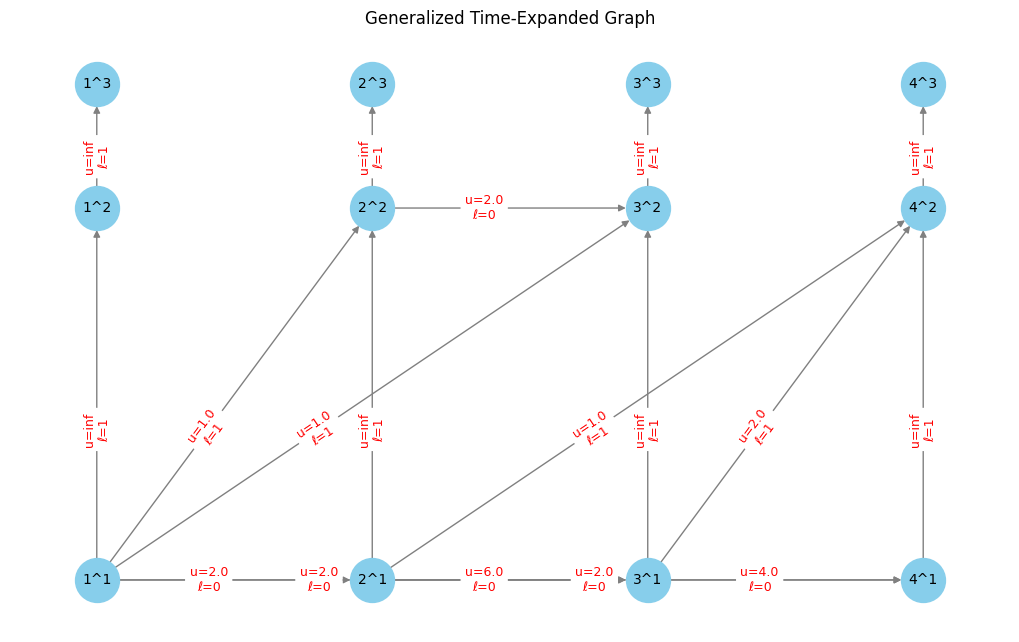

In [10]:
plot_GTEN(df, 'v^i', 'w^j', 'capacity', 'length', 'alpha_v', 'alpha_w')

4. Compute maximal s-t-flow

In [ ]:
flow_value, flow_dict= static_max_flow(df, 'v^i', 'w^j', 'capacity', 'length', sources=['1^1'], sinks=['4^3'])
cut_value, (reachable, non_reachable) = static_min_cut(df, 'v^i', 'w^j', 'capacity', 'length', sources=['1^1'], sinks=['4^3'])

Maximum flow with value: 4.0
Flow distribution:
1^1 -> 2^1: flow = 2.0, capacity = 2.0
1^1 -> 3^1: flow = 2.0, capacity = 2.0
2^1 -> 4^1: flow = 1.0, capacity = 2.0
2^1 -> 4^2: flow = 1.0, capacity = 1.0
3^1 -> 4^2: flow = 2.0, capacity = 2.0
4^1 -> 4^2: flow = 1.0, capacity = inf
4^2 -> 4^3: flow = 4.0, capacity = inf
4^3 -> T: flow = 4.0, capacity = inf
S -> 1^1: flow = 4.0, capacity = inf

Minimum cut value: 4.0
Source side {'1^1', '3^2', '2^2', '2^3', '1^3', '1^2', 'S', '3^3'}
Sink side {'2^1', 'T', '4^2', '4^1', '3^1', '4^3'}
Edges in the minimum cut:
1^1 -> 2^1: capacity = 2.0
1^1 -> 3^1: capacity = 2.0


In [ ]:
# Step 1: Create a directed graph with capacities and costs
G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_edge(row['v^i'], row['w^j'], capacity=row['capacity'], weight=row['length'])

# Step 2: Specify subsets of source and sink nodes
custom_sources = ['1^1']  # Define your source nodes here
custom_sinks = ['4^3']    # Define your sink nodes here

# Ensure that the specified nodes exist in the graph
source_nodes = [node for node in custom_sources if node in G.nodes]
sink_nodes = [node for node in custom_sinks if node in G.nodes]

# Step 3: Add a super-source and super-sink to combine specified sources and sinks
super_source = 'S'
super_sink = 'T'

# Add edges from super-source to all specified source nodes with infinite capacity
for source in source_nodes:
    G.add_edge(super_source, source, capacity=float('inf'),
               #weight=0
               )

# Add edges from all specified sink nodes to super-sink with infinite capacity
for sink in sink_nodes:
    G.add_edge(sink, super_sink, capacity=float('inf'), 
               #weight=0
               )

# Step 4: Compute the minimum-cost maximum flow
#flow_cost, flow_dict = nx.network_simplex(G)
flow_value, flow_dict = nx.maximum_flow(G, _s=super_source, _t=super_sink)
#min_cut_value, min_cut_dict = nx.minimum_cut(G, _s=super_source, _t=super_sink)
cut_value, (reachable, non_reachable) = nx.minimum_cut(G, super_source, super_sink, capacity='capacity')

# Step 5: Display results
# max flow
print(f"Maximum flow with value: {flow_value}")
print("Flow distribution:")
for u, v, data in G.edges(data=True):
    flow = flow_dict.get(u, {}).get(v, 0)
    if flow > 0:
        print(f"{u} -> {v}: flow = {flow}, capacity = {data['capacity']}"
              #, length = {data['weight']}"
              )
        
# min cut
print(f"\nMinimum cut value: {cut_value}")
print('Source side', reachable)
print('Sink side', non_reachable)
# extract the cut edges 
cutset = set()
for u, nbrs in ((n, G[n]) for n in reachable):
    cutset.update((u, v) for v in nbrs if v in non_reachable)
print("Edges in the minimum cut:")
for u, v in cutset:
    print(f"{u} -> {v}: capacity = {G[u][v]['capacity']}")



NameError: name 'nx' is not defined